# Functions

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
%matplotlib inline

In [56]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

In [57]:
dt = 0.01
tot = 1000
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

# Change mean Intensity

In [58]:
m = 4.037925
n =	1.0
alpha = 8.351984
beta = 3.123359
g =  442.699730
tau_y = 0.050404

In [59]:
C_tau_y = tau_y #s
C_tau_z = 0.25 #s
gamma = 0.7
I = np.zeros_like(x)
Ttemp = np.arange(0,int(C_tau_y/dt*15))*dt
C_Ky = Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)
Ttemp = np.arange(0,int(min(C_tau_z/dt*8,len(I)/2)))*dt
C_Kz = gamma*Ttemp/C_tau_y /C_tau_y *np.exp(-Ttemp/C_tau_y)+(1-gamma)*Ttemp/C_tau_z /C_tau_z *np.exp(-Ttemp/C_tau_z)

In [60]:
x = (x-np.mean(x))/np.std(x)*0.2+1 #basis: mean = 1, std = 0.2
sy = np.convolve(x, C_Ky, 'full')[:len(x)]*dt
sz = np.convolve(x, C_Kz, 'full')[:len(x)]*dt

In [61]:
dM_cone_list = []
horizontal_list = []
# s1_list = []

beta_c = 0.0002
beta_h = 0.01

Lum_list = 10**np.arange(0,5,0.5)
for Lum in Lum_list:
    s1 = sy*Lum
    s2 = sz*Lum
    cone = np.zeros(len(Taxis))
    horizontal = np.zeros(len(Taxis))
    for j in range(len(Taxis)-1):
        dc = dt*(-(1+beta_c*s2[j])*(alpha*cone[j]+n*horizontal[j]) + m*s1[j])
        dh = dt*(-(1+beta_h*cone[j])*beta*horizontal[j] + g*cone[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = horizontal[j]+dh
    dM_cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())

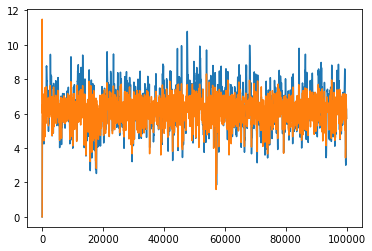

In [62]:
plt.plot(beta_c*s2)
plt.plot(beta_h*cone)
# plt.plot(cone*0.02)

# plt.plot( beta_c*s2*(alpha*cone[j]+horizontal[j]) )
# plt.plot( beta_h*cone*beta*horizontal )

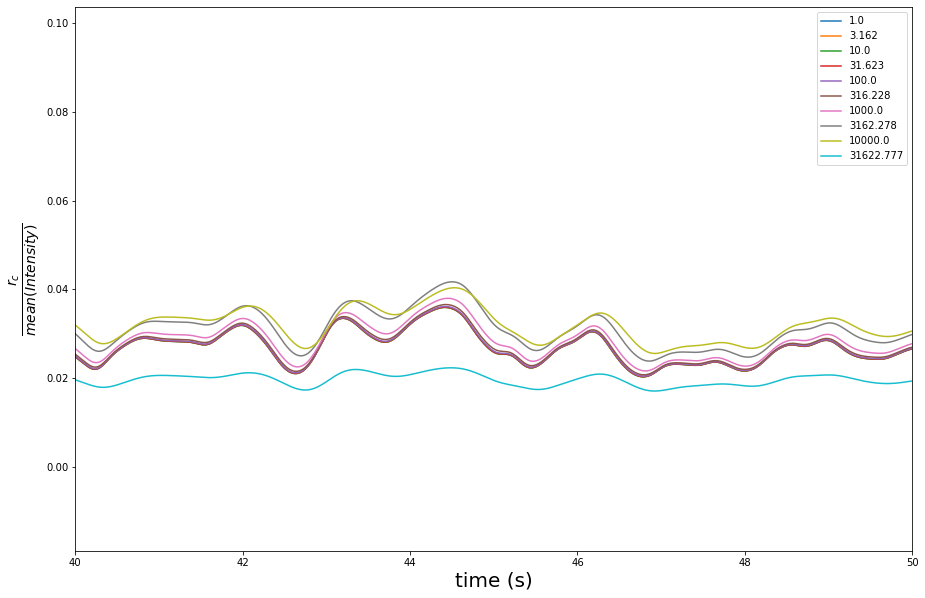

In [63]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(Taxis, dM_cone_list[L]/Lum_list[L], label = str(round(Lum_list[L], 3)))
plt.ylabel(r'$\frac{r_c}{mean(Intensity)}$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([40, 50])
# plt.ylim([-0.005, 0.005])
# plt.ylim([-0.05, 0.])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

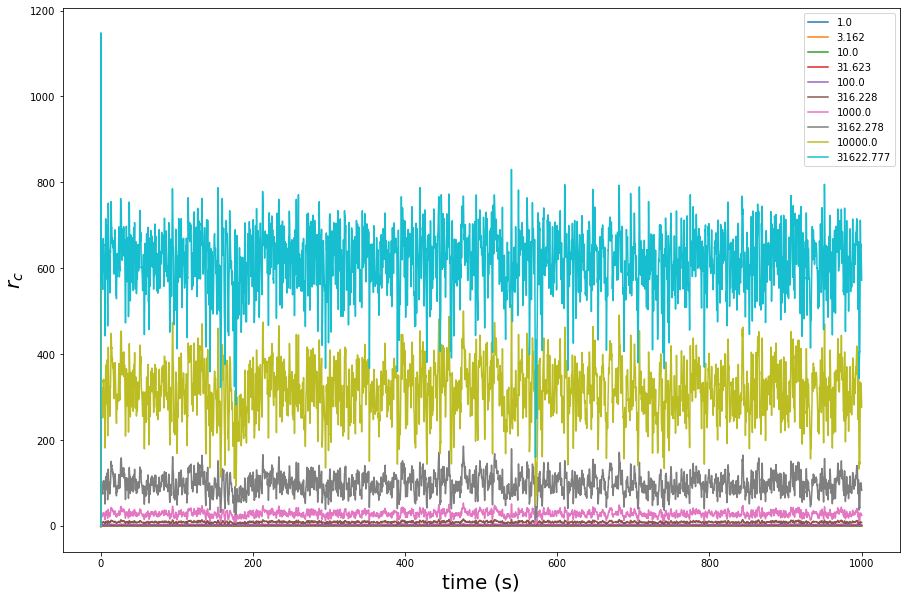

In [64]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for L in range(len(Lum_list)):
    plt.plot(Taxis, dM_cone_list[L], label = str(round(Lum_list[L], 3)))
plt.ylabel(r'$r_c$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
# plt.xlim([39, 44])
# plt.ylim([-0.005, 0.005])
# plt.ylim([-0.05, 0.01])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

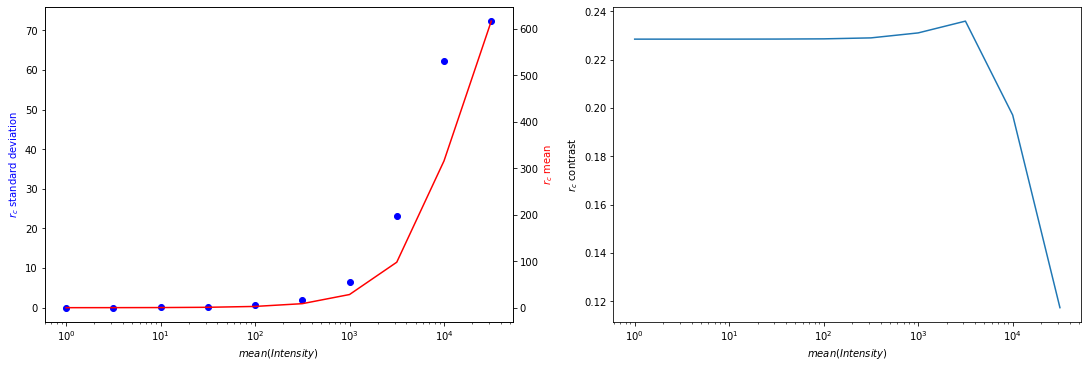

In [65]:
fig, (ax, ax0) = plt.subplots(1,2, constrained_layout=True)
r_c = np.array(dM_cone_list)

ax.scatter(Lum_list, np.std(r_c, axis = 1), c= 'b')
ax.set_ylabel(r'$r_c$ standard deviation',c='b')
ax.set_xlabel(r'$mean(Intensity)$')
ax.set_xscale('log')

ax2 = ax.twinx()
ax2.plot(Lum_list,np.mean(r_c, axis = 1), 'r')
ax2.set_ylabel(r'$r_c$ mean',c='r')

ax0.plot(Lum_list, np.std(r_c, axis = 1)/np.mean(r_c, axis = 1))
ax0.set_ylabel(r'$r_c$ contrast')
ax0.set_xlabel(r'$mean(Intensity)$')
ax0.set_xscale('log')

fig.set_size_inches(15,5)


## correlation (to r_base)

In [66]:
window = [-1, 1]
timeaxis = np.arange(window[0],window[1]+dt,dt)
dM_baseXcor_list = []
dM_b_precede = []
for cone in dM_cone_list:
    Xcorr = np.correlate(dM_cone_list[0], cone, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)+int(window[0]/dt) : int(len(Xcorr)/2)+1+int(window[1]/dt)]
    dM_baseXcor_list.append(Xcorr.copy())
    dM_b_precede.append(timeaxis[np.argmax(Xcorr)])

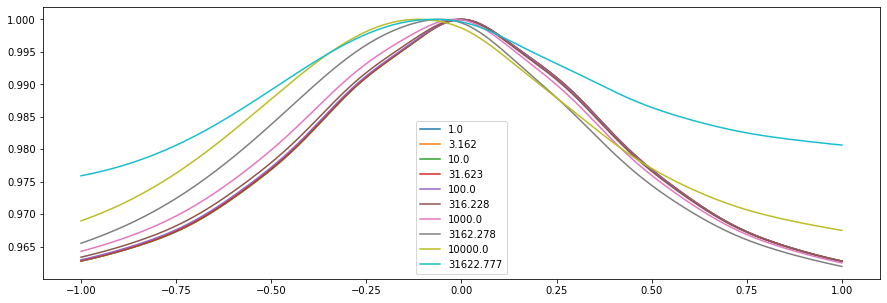

In [67]:
for L in range(len(Lum_list)):
    plt.plot(timeaxis, dM_baseXcor_list[L]/max(dM_baseXcor_list[L]), label = str(round(Lum_list[L], 3)))
plt.legend()
plt.gcf().set_size_inches(15, 5)

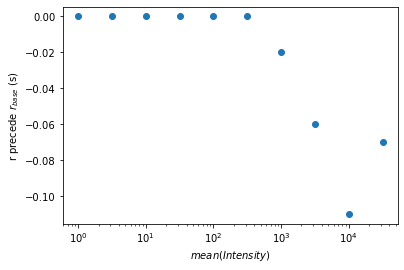

In [68]:
plt.scatter(Lum_list, dM_b_precede)
plt.ylabel(r'r precede $r_{base}$ (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

## STA

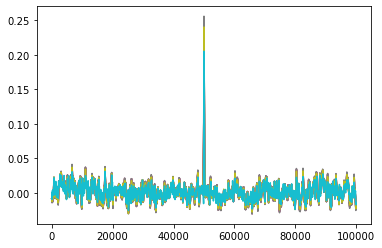

In [69]:
# window = [-1, 1]
# timeaxis = np.arange(window[0],window[1]+dt,dt)
dM_xXcor_list = []
dM_x_precede = []
for cone in dM_cone_list:
    Xcorr = np.correlate(x-1, NL(cone,np.mean(cone)), 'same')/ np.correlate(np.ones_like(x-1), NL(cone,np.mean(cone)), 'same')
    plt.plot(Xcorr)
    Xcorr = Xcorr[int(len(Xcorr)/2)+int(window[0]/dt) : int(len(Xcorr)/2)+1+int(window[1]/dt)]
    dM_xXcor_list.append(Xcorr.copy())
    dM_x_precede.append(timeaxis[np.argmax(Xcorr)])

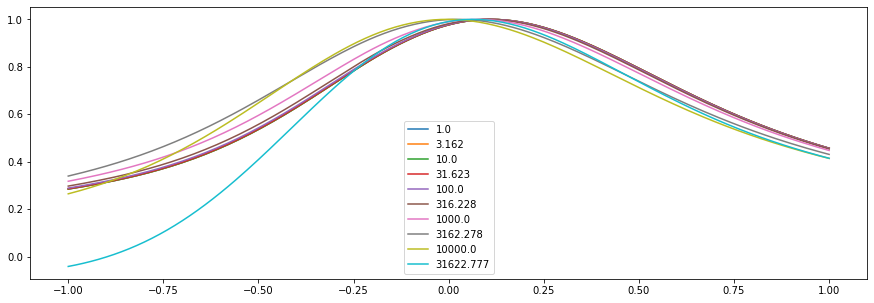

In [70]:
for L in range(len(Lum_list)):
    plt.plot(timeaxis, dM_xXcor_list[L]/max(dM_xXcor_list[L]), label = str(round(Lum_list[L], 3)))
plt.legend()
plt.gcf().set_size_inches(15, 5)

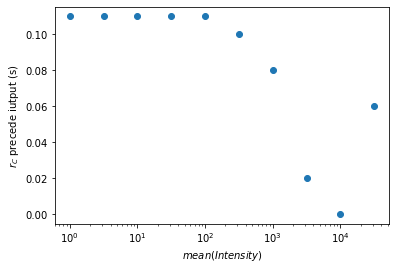

In [71]:
plt.scatter(Lum_list, dM_x_precede)
plt.ylabel(r'$r_C$ precede iutput (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

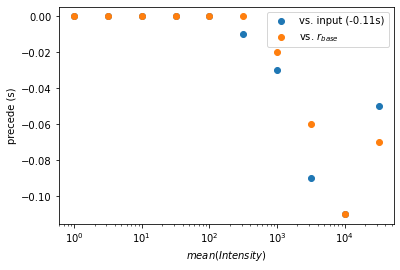

In [72]:
plt.scatter(Lum_list, dM_x_precede-dM_x_precede[0], label = 'vs. input (-'+str(round(dM_x_precede[0],3))+'s)')
plt.scatter(Lum_list, dM_b_precede, label = r'vs. $r_{base}$')
plt.ylabel('precede (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.legend(loc = 'best')
plt.xscale('log')

## MI

In [73]:
window = [-1,1]
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

dM_MI = [0]*len(Lum_list)
for L in range(len(Lum_list)):
    rstate = SG(dM_cone_list[L], dt, 0, 10, 10)
    timeshift, dM_MI[L] = MIfunc(rstate, xstate, dt, window)

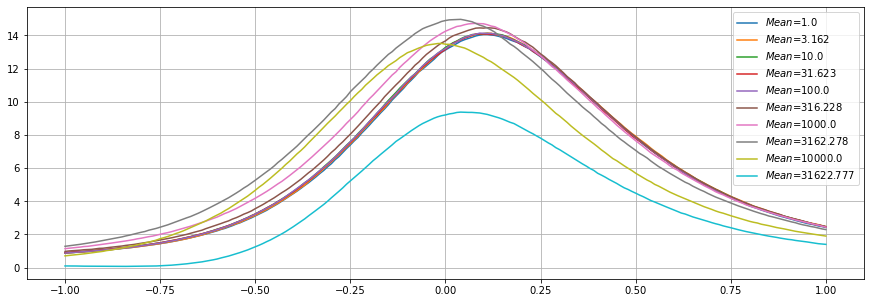

In [74]:
for L in range(len(Lum_list)):
    plt.plot(timeshift, dM_MI[L], label=r'$Mean$='+str(round(Lum_list[L],3)))

plt.legend(loc='best')
plt.grid()
plt.gcf().set_size_inches(15,5)

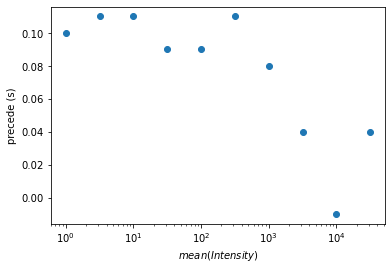

In [78]:
dM_MI_precede = [timeshift[np.argmax(MI)] for MI in dM_MI]

plt.scatter(Lum_list, dM_MI_precede)
# plt.scatter(Lum_list, dM_x_precede)
plt.ylabel('precede (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.xscale('log')

# Change Contrast

In [79]:
dC_cone_list = []
dC_x_list = []
horizontal_list = []
# s1_list = []

Con_list = np.linspace(0.03, 0.5, 5)
Lum = 10
for con in Con_list:
    xCon = ((x-np.mean(x))/np.std(x)*con+1)*Lum #basis: mean = 1
    dC_x_list.append(xCon.copy())
    s1 = np.convolve(xCon, C_Ky, 'full')[:len(x)]*dt
    s2 = np.convolve(xCon, C_Kz, 'full')[:len(x)]*dt

    cone = np.zeros(len(Taxis))
    horizontal = np.zeros(len(Taxis))
    for j in range(len(Taxis)-1):
        dc = dt*(-(1+beta_c*s2[j])*(alpha*cone[j]+n*horizontal[j]) + m*s1[j])
        dh = dt*(-(1+beta_h*cone[j])*beta*horizontal[j] + g*cone[j])
        cone[j+1] = cone[j]+dc
        horizontal[j+1] = horizontal[j]+dh
    dC_cone_list.append(cone.copy())
    horizontal_list.append(horizontal.copy())

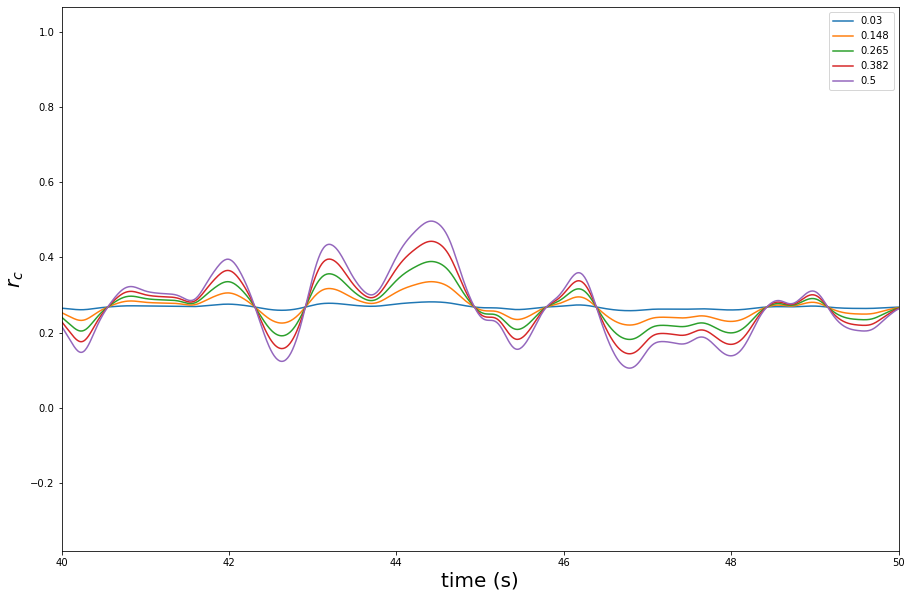

In [80]:
# plt.plot(x*alpha_c)
# plt.plot(sy*alpha_c)
for C in range(len(Con_list)):
    plt.plot(Taxis, dC_cone_list[C], label = str(round(Con_list[C],3)))
plt.ylabel(r'$r_c$', fontsize = 20)
plt.xlabel('time (s)', fontsize = 20)
plt.xlim([40, 50])
# plt.ylim([-0.04, -0.0])
# plt.ylim([-0.05, 0.])
plt.legend(loc='best')
plt.gcf().set_size_inches(15, 10)

Text(0.5, 0, 'Contrast ($\\frac{dM}{I}$)')

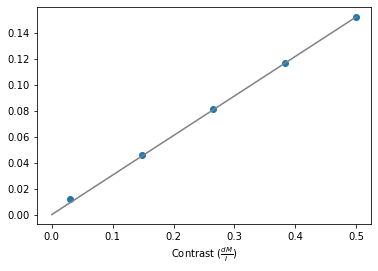

In [81]:
plt.scatter(Con_list, np.std(np.array(dC_cone_list), axis = 1))
plt.plot([0, Con_list[-1]], [0, np.std(np.array(dC_cone_list)[-1])], c= 'gray')
ax.set_ylabel(r'$r_c$ standard deviation')
plt.xlabel(r'Contrast ($\frac{dM}{I}$)')

## correlation (to r_base)

In [82]:
window = [-1, 1]
timeaxis = np.arange(window[0],window[1]+dt,dt)
dC_baseXcor_list = []
dC_b_precede = []
for cone in dC_cone_list:
    Xcorr = np.correlate(dC_cone_list[0], cone, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)+int(window[0]/dt) : int(len(Xcorr)/2)+1+int(window[1]/dt)]
    dC_baseXcor_list.append(Xcorr.copy())
    dC_b_precede.append(timeaxis[np.argmax(Xcorr)])

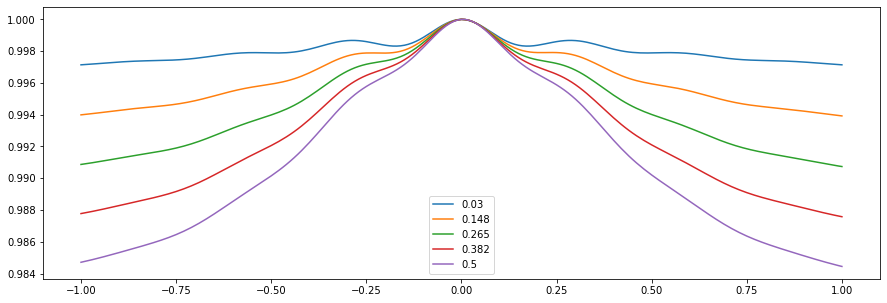

In [83]:
for C in range(len(Con_list)):
    plt.plot(timeaxis, dC_baseXcor_list[C]/max(dC_baseXcor_list[C]), label = str(round(Con_list[C],3)))
plt.legend()
plt.gcf().set_size_inches(15, 5)

Text(0.5, 0, '$mean(Intensity)$')

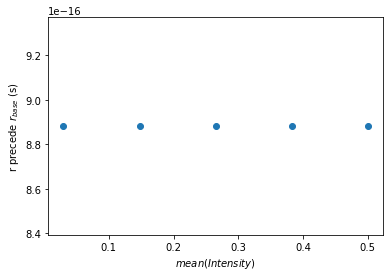

In [84]:
plt.scatter(Con_list, dC_b_precede)
plt.ylabel(r'r precede $r_{base}$ (s)')
plt.xlabel(r'$mean(Intensity)$')

## STA

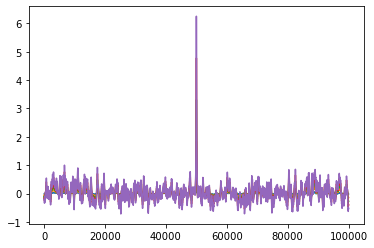

In [85]:
# window = [-1, 1]
# timeaxis = np.arange(window[0],window[1]+dt,dt)
dC_xXcor_list = []
dC_x_precede = []
counter = 0
for cone in dC_cone_list:
    # Xcorr = np.correlate(x-1, cone, 'same')
    Xcorr = np.correlate(dC_x_list[counter]-Lum, NL(cone,np.mean(cone)), 'same')/np.correlate(np.ones_like(x), NL(cone,np.mean(cone)), 'same')
    plt.plot(Xcorr)
    Xcorr = Xcorr[int(len(Xcorr)/2)+int(window[0]/dt) : int(len(Xcorr)/2)+1+int(window[1]/dt)]
    dC_xXcor_list.append(Xcorr.copy())
    dC_x_precede.append(timeaxis[np.argmax(Xcorr)])
    counter += 1

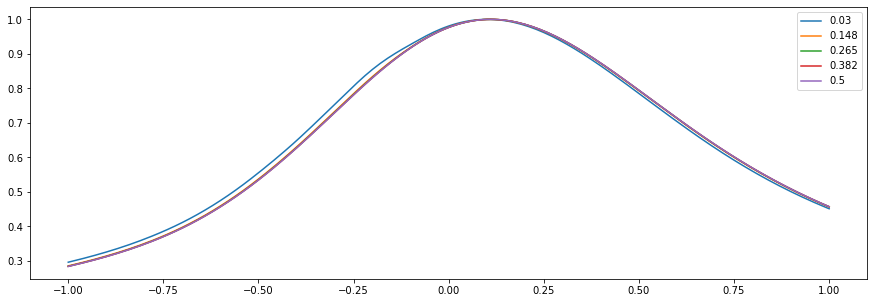

In [86]:
for C in range(len(Con_list)):
    plt.plot(timeaxis, dC_xXcor_list[C]/max(dC_xXcor_list[C]), label = str(round(Con_list[C],3)))
plt.legend()
plt.gcf().set_size_inches(15, 5)

Text(0.5, 0, '$mean(Intensity)$')

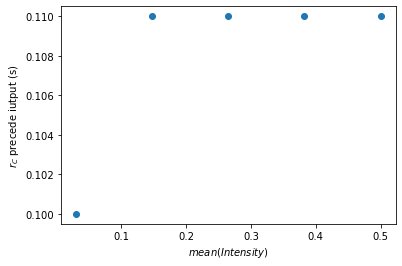

In [87]:
plt.scatter(Con_list, dC_x_precede)
plt.ylabel(r'$r_C$ precede iutput (s)')
plt.xlabel(r'$mean(Intensity)$')

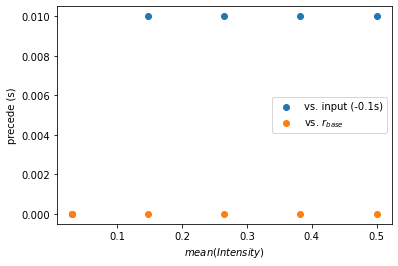

In [88]:
plt.scatter(Con_list, dC_x_precede-dC_x_precede[0], label = 'vs. input (-'+str(round(dC_x_precede[0],3))+'s)')
plt.scatter(Con_list, dC_b_precede, label = r'vs. $r_{base}$')
plt.ylabel('precede (s)')
plt.xlabel(r'$mean(Intensity)$')
plt.legend(loc = 'best')

In [89]:
window = [-1,1]
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

dC_MI = [0]*len(Con_list)
for C in range(len(Con_list)):
    rstate = SG(dC_cone_list[C], dt, 0, 10, 10)
    timeshift, dC_MI[C] = MIfunc(rstate, xstate, dt, window)

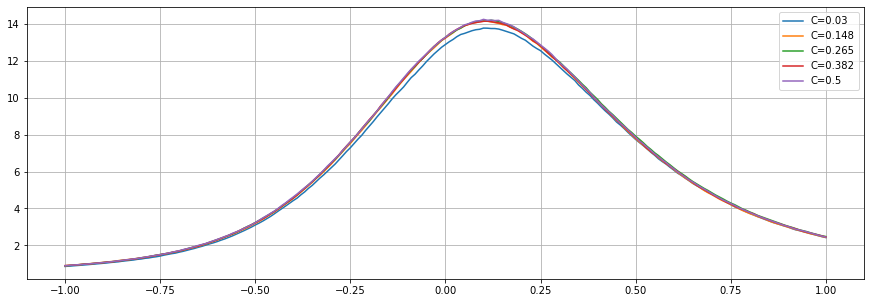

In [90]:
for C in range(len(Con_list)):
    plt.plot(timeshift, dC_MI[C], label = 'C='+str(round(Con_list[C],3)))

plt.legend(loc='best')
plt.grid()
plt.gcf().set_size_inches(15,5)

Text(0.5, 0, '$mean(Intensity)$')

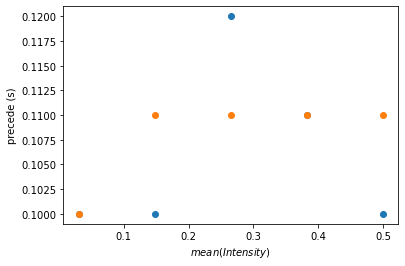

In [91]:
dC_MI_precede = [timeshift[np.argmax(MI)] for MI in dC_MI]

plt.scatter(Con_list, dC_MI_precede)
plt.scatter(Con_list, dC_x_precede)
plt.ylabel('precede (s)')
plt.xlabel(r'$mean(Intensity)$')